# Pizza slicer based on Yolov3 and Ultra96-V2 board

The last section explains the Pizza Slicer code. The whole program is written in python3 and usees a jupyter notebook to control the program.
The first three cells cover all Python imports and FPGA / DPU file loading.

In [1]:
#Python imports
from pynq import allocate, Overlay
from pynq.lib.video import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib notebook
import operator
import time as t
import PIL.Image
import cv2
from skimage.transform import rotate

In [2]:
#Load the FGPA bin file, just for testing 
base_overlay = Overlay("pizza.bit")

In [ ]:
#Load the FGPA bin file
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("pizza.bit")
overlay.load_model("pizza.elf")

Generate Slicing masks. The problem of finding the best angle is solved geometrically. I used 180 masks, which cut the 320 x 320 image into two parts. The comment code, enable matplotlib plots which draw the slicing maks. 


The image show the slicing maks for 10; 70 and 145 degree 

![Slicing Maks](img/SlicingMasks.png)


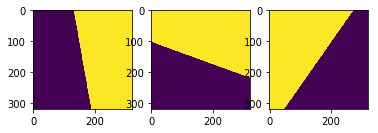

In [3]:
#Generate the slicing masks, from 0 to 180 degree cutting angle 
base_array_zero = np.zeros((640, 320))
base_array_once = np.full((640, 320),255, dtype=np.uint8)

base_array = np.hstack([base_array_zero, base_array_once])

mask_dict = {}

for i in range(0, 181):
    tmp_rot = rotate(base_array, i, center=(320, 320))
    tmp_mask = tmp_rot[160:480, 160:480]
    uint_mask = tmp_mask.astype('uint8')
    mask_dict[i] = uint_mask

#print(uint_mask.shape)
#print(uint_mask)    

#fig, axs = plt.subplots(1, 3)

#axs[0].imshow(mask_dict[10])
#axs[1].imshow(mask_dict[70])
#axs[2].imshow(mask_dict[145])
#plt.show()

## Output images 

### Base Background 
![Slicing Maks](Pizza_1.png)

### "Cut Here" Background
![Slicing Maks](Pizza_1_cut_here.png)

### "rotated arrows"
![Slicing Maks](Pizza_1_arrow.png)


In [ ]:
# Load images for projection 
out_img_bg = cv2.imread("Pizza_1.png")
out_img_cut_here = PIL.Image.open("Pizza_1_cut_here.png")
out_img_arrow = PIL.Image.open("Pizza_1_arrow.png")
#out_img_bg.shape

Loading anchors for Yolov3 network. Yolov3 uses a fixed set of anchors to generate the bounding boxes. These anchors are used in the evaluation function.

In [ ]:
# Yolov3 anchro list, used to find the bounding boxes

anchor_list = [10,13,16,30,33,23,30,61,62,45,59,119,116,90,156,198,373,326]
anchor_float = [float(x) for x in anchor_list]
anchors = np.array(anchor_float).reshape(-1, 2)

KERNEL_CONV="tf_yolov3"
CONV_INPUT_NODE="conv2d_1_convolution"
CONV_OUTPUT_NODE1="conv2d_59_convolution"
CONV_OUTPUT_NODE2="conv2d_67_convolution"
CONV_OUTPUT_NODE3="conv2d_75_convolution"

The evaluation function converts the Yolov3 output to boxes, classes and scores. This is needed because all other steps need the output in bounding boxes format.

In [ ]:
# Yolov3 output evaluation function 
def evaluate(yolo_outputs, image_shape, class_names, anchors):
    score_thresh = 0.2
    anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
    boxes = []
    box_scores = []
    input_shape = np.shape(yolo_outputs[0])[1 : 3]
    input_shape = np.array(input_shape)*32

    for i in range(len(yolo_outputs)):
        _boxes, _box_scores = boxes_and_scores(
            yolo_outputs[i], anchors[anchor_mask[i]], len(class_names), 
            input_shape, image_shape)
        boxes.append(_boxes)
        box_scores.append(_box_scores)
    boxes = np.concatenate(boxes, axis = 0)
    box_scores = np.concatenate(box_scores, axis = 0)

    mask = box_scores >= score_thresh
    boxes_ = []
    scores_ = []
    classes_ = []
    for c in range(len(class_names)):
        class_boxes_np = boxes[mask[:, c]]
        class_box_scores_np = box_scores[:, c]
        class_box_scores_np = class_box_scores_np[mask[:, c]]
        nms_index_np = nms_boxes(class_boxes_np, class_box_scores_np) 
        class_boxes_np = class_boxes_np[nms_index_np]
        class_box_scores_np = class_box_scores_np[nms_index_np]
        classes_np = np.ones_like(class_box_scores_np, dtype = np.int32) * c
        boxes_.append(class_boxes_np)
        scores_.append(class_box_scores_np)
        classes_.append(classes_np)
    boxes_ = np.concatenate(boxes_, axis = 0)
    scores_ = np.concatenate(scores_, axis = 0)
    classes_ = np.concatenate(classes_, axis = 0)

    return boxes_, scores_, classes_

HDMI setup for camera input and projector output. The code is compatible with the PYNQ HDMI interface. A custom in/output can be set up at this point.

In [ ]:
#Setup HDMI
hdmi_in = base_overlay.video.hdmi_in
hdmi_out = base_overlay.video.hdmi_out
hdmi_in.configure(PIXEL_RGB)

#hdmi_in.configure()
hdmi_out.configure(hdmi_in.mode)

hdmi_in.start()
hdmi_out.start()

In [ ]:
##Print default output on projector
outframe = hdmi_out.newframe()
cv2.cvtColor(out_img_bg, cv2.COLOR_RGB2BGR,dst=outframe)
hdmi_out.writeframe(outframe)

In [ ]:
#Test Input framerate
numframes = 600
start = t.time()

for _ in range(numframes):
    frame = hdmi_in.readframe()

    
end = t.time()
print("Frames per second:  " + str(numframes / (end - start)))

In [ ]:
# Show input frame from camera
frame = hdmi_in.readframe()
#image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
image_Pil = PIL.Image.fromarray(frame)
#image?
image_Pil

## Input Image preparation

The input image from the camera is cropped in the first step, to select the region of interest (ROI). My GoPro Camera outputs a 720p image, so the ROI is set to 440 x 440 pixels, cropping is done in the software. This is useful if your camera is not fixed at the projector and some adjustments are needed to fit the pizza in the middle of the ROI. The ROI image data is transferred to the FPGA image resizer, the data transfer is done by some DMA tasks. To enable data transfer from the python memory to the PL memory, the pynq.buffer is used. The output from the PL image resizer is used as  DPU input. The source code from PL resizer is forked from this PYNQ-Helloworld GitHub repo. The PL resizer can handle custom in/ output images, the settings for in/output images can be set via registers. Four register values must be set: 0x10 : input image height ; 0x18 input image width; 0x20 output image height; 0x28 output image width

In [ ]:
## setup PL resizer 

#Setup image resizer dmas 
resize_dma = base_overlay.axi_dma_0
resizer_accelerator = base_overlay.resize_accel_0

# configure resizer registers 
resizer_accelerator.write(0x10, 440)
resizer_accelerator.write(0x18, 440)
resizer_accelerator.write(0x20, 320)
resizer_accelerator.write(0x28, 320)


In [ ]:
#Buffers 
hdmi_input = allocate(shape=(720, 1280, 3),dtype=np.uint8)
hdmi_input_crop = allocate(shape=(440, 440, 3),dtype=np.uint8)
hdmi_resized = allocate(shape=(320, 320, 3), dtype=np.uint8)


In [ ]:
# read input, crop and use PL resizer for DPU image size 
input_frame = np.array(hdmi_in.readframe())
resizer_input = input_frame[220:660,400:840]
resizer_input.shape
hdmi_input_crop[:] = resizer_input
hdmi_input_crop.sync_to_device()

resize_dma.sendchannel.transfer(hdmi_input_crop)
resize_dma.recvchannel.transfer(hdmi_resized)    
resizer_accelerator.write(0x00,0x81) # start
resize_dma.sendchannel.wait()
resize_dma.recvchannel.wait()
hdmi_resized.sync_from_device()

resized_input_array = np.array(hdmi_resized)
resized_input_array.shape

pil_dpu_image = PIL.Image.fromarray(resized_input_array)
pil_dpu_image

In [ ]:
#This is used for recording training images 
from datetime import timezone 
import datetime 
# Getting the current date  
# and time 
dt = datetime.datetime.now() 
  
utc_time = dt.replace(tzinfo = timezone.utc) 
utc_timestamp = utc_time.timestamp() 
int_utc_time = int(utc_timestamp)

# read input, crop and use PL resizer for DPU image size 
input_frame = np.array(hdmi_in.readframe())
resizer_input = input_frame[220:660,400:840]
resizer_input.shape
hdmi_input_crop[:] = resizer_input
hdmi_input_crop.sync_to_device()

resize_dma.sendchannel.transfer(hdmi_input_crop)
resize_dma.recvchannel.transfer(hdmi_resized)    
resizer_accelerator.write(0x00,0x81) # start
resize_dma.sendchannel.wait()
resize_dma.recvchannel.wait()
hdmi_resized.sync_from_device()

resized_input_array = np.array(hdmi_resized)
resized_input_array.shape

pil_dpu_image = PIL.Image.fromarray(resized_input_array)
pil_dpu_image.save(str(int_utc_time) + "_pizza.jpg")

## DPU setup

DPU init and DPU Task starting. The evaluation function converts the raw Yolov3 network output to bounding boxes format. 

In [ ]:
#init n2cube for DPU handling
import n2cube 
n2cube.dpuOpen()

kernel = n2cube.dpuLoadKernel(KERNEL_CONV)
task = n2cube.dpuCreateTask(kernel, 0)


In [ ]:
#prepare input data and run dpu task

input_len = n2cube.dpuGetInputTensorSize(task, CONV_INPUT_NODE)
opencvImage = cv2.cvtColor(np.array(resized_input_array), cv2.COLOR_RGB2BGR)

n2cube.dpuSetInputTensorInHWCFP32(task, CONV_INPUT_NODE, opencvImage, input_len)
n2cube.dpuRunTask(task)

#plt.imshow(cv2.cvtColor(opencvImage, cv2.COLOR_BGR2RGB))
#plt.show()


In [ ]:
#### Load Test image or use web cam input #### 

input_len = n2cube.dpuGetInputTensorSize(task, CONV_INPUT_NODE)
opencvImage = cv2.imread("pizza_5.jpg")
#opencvImage = cv2.imread("1606875273_pizza.jpg")
opencvImage.shape

n2cube.dpuSetInputTensorInHWCFP32(task, CONV_INPUT_NODE, opencvImage, input_len)
n2cube.dpuRunTask(task)

#plt.imshow(cv2.cvtColor(opencvImage, cv2.COLOR_BGR2RGB))
#plt.show()


In [ ]:
conv_sbbox_size = n2cube.dpuGetOutputTensorSize(task, CONV_OUTPUT_NODE1)
conv_out1 = n2cube.dpuGetOutputTensorInHWCFP32(task, CONV_OUTPUT_NODE1, 
                                               conv_sbbox_size)
conv_out1 = np.reshape(conv_out1, (1, 13, 13, 75))

conv_mbbox_size = n2cube.dpuGetOutputTensorSize(task, CONV_OUTPUT_NODE2)
conv_out2 = n2cube.dpuGetOutputTensorInHWCFP32(task, CONV_OUTPUT_NODE2, 
                                               conv_mbbox_size)
conv_out2 = np.reshape(conv_out2, (1, 26, 26, 75))

conv_lbbox_size = n2cube.dpuGetOutputTensorSize(task, CONV_OUTPUT_NODE3)
conv_out3 = n2cube.dpuGetOutputTensorInHWCFP32(task, CONV_OUTPUT_NODE3, 
                                               conv_lbbox_size)
conv_out3 = np.reshape(conv_out3, (1, 52, 52, 75))

yolo_outputs = [conv_out1, conv_out2, conv_out3]

outs = evaluate(yolo_outputs, image_size, class_names, anchors)

## Pepperoni heatmap creation

The output from the evaluation function is passed to a sorting process. Duplicate pizza detections are removed, only the highest confidence for pizza is used. Pepperoni detections are used if the confidence is higher than 0.5.

In [ ]:
#create pepperoni heatmap 

base_array = np.zeros((320,320), dtype=np.uint8)
pepperoni_map = ()

#Image dimensions
height = 320
width = 320
channels = 3


class_ids=[]
confidences=[]
ellipses=[]

dnn_detection={}
cnt=0

for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x= int(detection[0]*width)
            center_y= int(detection[1]*height)
            w = int((detection[2]*width)/2)
            h = int((detection[3]*height)/2)
            #x=int(center_x - w/2)
            #y=int(center_y - h/2)
            
            x=int(center_x)
            y=int(center_y)
            
            #append object to dict 
            dnn_detection[str(cnt)] = ([x,y,w,h],float(confidence),class_id)
            cnt = cnt +1 
            #ellipses.append([x,y,w,h]) 
            #confidences.append(float(confidence))
            #class_ids.append(class_id) 

print("found {} objects".format(len(dnn_detection)))
#dnn_detection

### Elliptic approximation

Based on the sorting out process, a virtual pizza is drawn in a 320 x320 uint8 array. The bounding box coordinates are used to draw an ellipse inside the bounding box. The inside of the ellipse is filled with 1 the outside with 0. Every pepperoni approximation is added to the 320 x 320 base array. The base array element is a pizza bounding box approximation. Pepperoni detections outside the pizza base array are ignored. The result is a pepperoni heatmap.

In [ ]:
#pizza has id 1, pepperoni has id 0 
#sort the dection dict 

found_pizza = False 
pepperoni_map = list()

sorted_dict = dict( sorted(dnn_detection.items(),key=operator.itemgetter(1)))
#print(sorted_dict)
for item in sorted_dict:
    #print(sorted_dict[item])
    tmp_item = sorted_dict[item]
    
    if tmp_item[2] == 1 and not found_pizza:
        found_pizza = True
        pizza_base = cv2.ellipse(base_array, (tmp_item[0][0],tmp_item[0][1]),(tmp_item[0][2],tmp_item[0][3]), 0, 0, 360,1,-1)
    if tmp_item[2] == 0:
        tmp_base = np.zeros((320,320), dtype=np.uint8)
        pepperoni_map.append(cv2.ellipse(tmp_base,(tmp_item[0][0],tmp_item[0][1]),(tmp_item[0][2],tmp_item[0][3]), 0, 0, 360,1,-1))

pizza_heatmap = pizza_base
        
#remove pepperoni detection outside the pizza         
for pepperoni in pepperoni_map:
    tmp_map = cv2.bitwise_and(pizza_base,pepperoni)
    pizza_heatmap = pizza_heatmap + tmp_map 


Pepperoni heatmap, overlaying pepperoni slices are also simulated (brighter areas). That is one reason, why an object detection network is used instead of a segmentation network. With the object detection network and the elliptic area approximation overlaying pepperonis can be simulated.


### Testimage Yolov3 heatmap
![Slicing Maks](img/TestimageYolov3compare.png)


In [ ]:
#show the images, detection versus compare yolov2 input 

# make the images bigger for browser rendering 
plt.rcParams['figure.dpi'] = 200
fig, axs = plt.subplots(1, 2)
axs[0].imshow(pizza_heatmap)
axs[1].imshow(cv2.cvtColor(opencvImage,cv2.COLOR_BGR2RGB))
plt.show()

### 3D pepperoni heatmap of test image

![Slicing Maks](img/TestimageHeatmap.png)


In [ ]:
#Nice 3d view of the heatmap

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111, projection='3d')

x = np.arange(0,320,1)
y = np.arange(0,320,1)
X,Y = np.meshgrid(x,y)
X.shape
Z = pizza_heatmap

mycmap = plt.get_cmap('YlOrRd')
ax1.set_title('Pepperoni heatmap')
surf1 = ax1.plot_surface(X, Y, Z, cmap=mycmap)
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
plt.show()

In [ ]:
# calculate the optimal cutting angel 
# I solve this problem geometrical applying a "mask" to the heatmap and do a binary search for the best cutting angle
heat_map_sum = np.sum(pizza_heatmap)
half_heat_map_sum = heat_map_sum/2



In [ ]:
#do a binary search for prefect slice angle, i search the pos/neg crossing for (half_heat_map_sum - sum of current angle) 
start = 0
step = 0
low = 0
mid = 90
high = 180
end = 180
diff = -1

tmp_sum_heatmap = np.zeros((320,320))

while (low != mid):  
    np.bitwise_and(pizza_heatmap,mask_dict[low],tmp_sum_heatmap)
    uint_tmp_sum_heatmap_low = tmp_sum_heatmap.astype('uint8')
    tmp_sum_low = np.sum(uint_tmp_sum_heatmap_low)
    diff_low = half_heat_map_sum - tmp_sum_low
    
    np.bitwise_and(pizza_heatmap,mask_dict[mid],tmp_sum_heatmap)
    uint_tmp_sum_heatmap_mid = tmp_sum_heatmap.astype('uint8')
    tmp_sum_mid = np.sum(uint_tmp_sum_heatmap_mid)
    diff_mid = half_heat_map_sum - tmp_sum_mid
    
    np.bitwise_and(pizza_heatmap,mask_dict[high],tmp_sum_heatmap)
    uint_tmp_sum_heatmap_high = tmp_sum_heatmap.astype('uint8')
    tmp_sum_high = np.sum(uint_tmp_sum_heatmap_high)
    diff_high = half_heat_map_sum - tmp_sum_high
    
    print("Step {},difference mid : {} Angels: low: {}, mid: {} high: {}".format(step,diff_mid,low,mid,high))
    
    if (diff_low == half_heat_map_sum):
        mid = low
        break
    if (diff_mid == half_heat_map_sum):
        break
    
    if (diff_high == half_heat_map_sum):
        mid = high
        break   

    #check for 
    if diff_low > 0 and diff_mid < 0:
        #set new search between low and mid
        low = low
        mid = int(low + ((high - low)/2))
        high = mid 
        
    else:
        #set new search between mid and high
        low = mid
        mid = int(low + ((high - low)/2))
        high = high
    
    step = step +1 
    #check for finish
    if(low + 1 == mid):
        break
    
print("Found best angel at: {} diff: {}".format(mid, diff_mid))    

### 3D pippa slice heatmap of test image

![Slicing Maks](img/TestimageSliceHeatmap.png)


In [ ]:
#Draw the slice in 3d 
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111, projection='3d')

x = np.arange(0,320,1)
y = np.arange(0,320,1)
X,Y = np.meshgrid(x,y)
X.shape
Z = uint_tmp_sum_heatmap_mid

mycmap = plt.get_cmap('YlOrRd')
ax1.set_title('Pepperoni slice heatmap')
surf1 = ax1.plot_surface(X, Y, Z, cmap=mycmap)
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
plt.show()    

In [ ]:
# Draw the slice angle
mid = 45

if mid <= 90:
    # counter clockwise
    out_cut_image = out_img_arrow.rotate(90 - mid)
else:
    out_cut_image = out_img_arrow.rotate(360 - (mid -90))

outframe = hdmi_out.newframe()
#Blend the two images
slice_output = PIL.Image.blend(out_img_cut_here,out_cut_image,0.5)

#Write out frame
outframe = hdmi_out.newframe()
cv2.cvtColor(np.array(slice_output), cv2.COLOR_RGB2BGR,dst=outframe)
hdmi_out.writeframe(outframe)